**AI FACE MASK DETECTOR- KFOLD**


**There are 5 classes:No mask, cloth mask, surgical mask, FFP2, N95 with a valve**

In [3]:
from google.colab import drive
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from PIL import Image
import seaborn as sns
from torch.utils.data.dataset import Dataset
from torchvision.transforms import ToPILImage, Compose, ToTensor, Resize, Normalize
from torchvision import transforms
import cv2
from torch.utils.data.dataset import Dataset, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torch
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import warnings
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix


Mounting the drive and assigning the paths

In [4]:

from google.colab import drive
drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)
root_directory = "/content/drive/MyDrive/Data"
saved_converted_image = "/content/drive/MyDrive/Colab Notebooks.npy"
saved_model = "/content/drive/MyDrive/FINAL_DATASET/saved_model"
sample_image_path = "/content/drive/MyDrive/FINAL_DATASET/sample_images"

Mounted at /content/drive
Mounted at /content/drive


Function for mapping labels with respective images

In [5]:

def map_image_with_label(data_class):
  label_name = [i for i in range(len(data_class))]
  #print(label_name)

  label_dictionary = dict(zip(data_class,label_name))
  print(label_dictionary)
  
  return label_dictionary 

Function for creating numpy image Array

In [6]:

def create_image_numpy_array(data_class, root_directory, label_dict):
  numpy_array_of_images = []
  for label in data_class:
    data_path = os.path.join(root_directory, label)
    image_names = os.listdir(data_path)
    print(label + "-->")
    for image in tqdm(image_names):
      image_path = os.path.join(data_path, image)
      images = cv2.imread(image_path) 
      try:
        imag = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
        img = cv2.resize(imag, (100,100))
        
        numpy_array_of_images.append((img, label_dict[label]))
      except Exception as e:
        print(e)

  return numpy_array_of_images

Function to shuffle the npy data and save it to the same file

In [7]:

def shuffle_and_save(data, saved_converted_image):
  np.random.shuffle(data)  
  np.save(saved_converted_image, data)


Function for transforming and normalizing the dataset

In [8]:

class NormalizingDataset(Dataset):
  def __init__(self, data):
    self.data = data
    self.transformation = transforms.Compose([
                                   transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                   Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                                   transforms.Resize((64,64))#image size changed
                                   ])
  
  def __getitem__(self, id):
    return self.transformation(self.data[id][0]), torch.tensor(self.data[id][1])
  
  def __len__(self):
    return self.data.__len__()


In [9]:
def dataset_loader(save_dir):
  data = np.load(save_dir, allow_pickle=True)
  loaded_dataset = NormalizingDataset(data)
  return loaded_dataset

## **Convolutional neural network architecture**

In [38]:

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(
        
        #Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.02),
       
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.02),


        #Layer 3
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.02),
       
        #Layer 4
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.02),

        #Layer 5
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.05),
    )
    
    #Fully Connected Layer
    self.linear_layers = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(512 * 6 * 6, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(64,5)
    )

  def forward(self, x):
    x = self.conv_layer(x)
    #print(x.shape)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

Function for executing epochs while training the model

In [12]:

def looping_through_epoch(train_loader,model,loss_criteria,training_loss_list,optimizer,training_accuracy_list,epoch_number):
  for epoch in range(epoch_number):
    for i, (images, labels) in enumerate(train_loader):
      outputs = model(images)

      #Forward Pass
      training_loss = loss_criteria(outputs, labels)
      training_loss_list.append(training_loss.item())

      #Backpropogation and Optimization
      optimizer.zero_grad()
      training_loss.backward()
      optimizer.step()

      #Training Accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      training_accuracy_list.append(correct / total)

    print('Epoch {}/{}, Loss--> {:.4f}, Accuracy--> {:.2f}%'
        .format(epoch + 1, epoch_number, training_loss.item(),
        (correct / total) * 100))



Function for training the model on the dataset based on the specified epoch number

In [13]:

def train_model(train_loader, test_loader, epoch_number):
  model = CNN()
  loss_criteria = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  training_accuracy_list = []
  training_loss_list = []
  looping_through_epoch(train_loader,model,loss_criteria,training_loss_list,optimizer,training_accuracy_list,epoch_number)
  return model
  

Function for creating confusion matrix

In [14]:

def create_confusion_matrix(model, title, load_data, classes):
  model.eval()
  predictions = []
  accurate_list = []
  with torch.no_grad():
    for images, labels in load_data:
      outputs = model(images)
      _, predicted = torch.max(model(images), 1)
      predictions.extend(predicted.detach().cpu().numpy())
      accurate_list.extend(labels.detach().cpu().numpy())
  
  print("{} Classification Report: ".format(title))
  print(classification_report(predictions, accurate_list))
  print("{} Confusion Matrix: ".format(title))
  
  confusion_matrix_data = confusion_matrix(accurate_list, predictions)
 
  #Plotting confusion matrix
  plot_confusion_matrix(confusion_matrix_data)

Function for plotting confusion matrix

In [15]:

def plot_confusion_matrix(confusion_matrix_data):
  conf_matrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g',cmap="Blues")

  conf_matrix.set_title('Confusion Matrix');
  conf_matrix.set_xlabel('Actual category')
  conf_matrix.set_ylabel('Predicted category');

  conf_matrix.xaxis.set_ticklabels(['surgical_mask', 'cloth_mask', 'ffp2_mask','no_mask', 'N95_with_mask'])
  conf_matrix.yaxis.set_ticklabels(['surgical_mask', 'cloth_mask', 'ffp2_mask','no_mask', 'N95_with_mask'])

  plt.setp(conf_matrix.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  plt.setp(conf_matrix.get_yticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
  plt.show()



Function for predicting the class for the given image

In [16]:

def predict_image(image_path, model, data_classes):
  image_names = os.listdir(image_path)
  label = {i for i in range(len(data_classes))}
  label_dict = dict(zip(label,data_classes))
  for images in image_names:
    print("\n")
    loader = transforms.Compose([  
                                   transforms.ToTensor(),
                                  Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                                   transforms.Resize((64,64))  #image resize                               
                              ])
    image_name = os.path.join(sample_image_path, images)
    img = cv2.imread(image_name)
    img = cv2.resize(img,(0,0),fx=1,fy=1)
    cv2_imshow(img)
    image = Image.open(image_name)
    image = loader(image).float()
    image = image.unsqueeze(0)
    
    _, predicted = torch.max(model(image), dim=1)

    pre = predicted[0]
    key = pre.item()
    print(label_dict[key])
    

**Here we have used gender and age based classification**

Classification on basis of gender - Male and Female




In [17]:

female_cloth_mask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/female/Cloth"
female_surgical_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/female/Surgical"
female_ffp2_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/female/FFP2"
female_nomask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/female/No_Mask"
female_ffp2valve_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/female/N95_with_valve"

male_cloth_mask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/male/Cloth"
male_surgical_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/male/Surgical"
male_ffp2_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/male/FFP2"
male_nomask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/male/No_Mask"
male_ffp2valve_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/gender/male/N95_with_valve"


Classification on basis of age - Children, Young , Old

In [18]:

young_cloth_mask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/young/Cloth"
young_surgical_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/young/Surgical"
young_ffp2_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/young/FFP2"
young_nomask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/young/No_Mask"
young_ffp2valve_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/young/N95_with_valve"

children_cloth_mask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/children/Cloth"
children_surgical_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/children/Surgical"
children_ffp2_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/children/FFP2"
children_nomask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/children/No_Mask"
children_ffp2valve_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/children/N95_with_valve"

old_cloth_mask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/old/Cloth"
old_surgical_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/old/Surgical"
old_ffp2_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/old/FFP2"
old_nomask_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/old/No_Mask"
old_ffp2valve_dir ="/content/drive/My Drive/FINAL_DATASET/Test_categories/age/old/N95_with_valve"


**Function for loading data**

In [24]:
def load_data(image_data, path, class_label):
  
  image_names = os.listdir(path)
  print("Image Labels", class_label)
  for image in tqdm(image_names):
    image_path = os.path.join(path, image)
    images = cv2.imread(image_path) 
    try:
      imag = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
      img = cv2.resize(imag, (100,100))
          

      image_data.append((img, class_label))
        
    except Exception as e:
      print(e)
  return image_data

Loading the data belonging to age and gender categories and assigning classes

In [37]:
print("************ Gender -- Female ************ ")
mask_female_data = []
mask_female_data = load_data(mask_female_data, female_cloth_mask_dir, 0)
mask_female_data = load_data(mask_female_data, female_surgical_dir , 1)
mask_female_data = load_data(mask_female_data, female_ffp2_dir,  2)
mask_female_data = load_data(mask_female_data, female_nomask_dir, 3)
mask_female_data = load_data(mask_female_data, female_ffp2valve_dir, 4)

print("************ Gender -- Male ************ ")
mask_male_data = []
mask_male_data = load_data(mask_male_data, male_cloth_mask_dir , 0)
mask_male_data = load_data(mask_male_data, male_surgical_dir, 1)
mask_male_data = load_data(mask_male_data, male_ffp2_dir, 2)
mask_male_data = load_data(mask_male_data, male_nomask_dir, 3)
mask_male_data = load_data(mask_male_data, male_ffp2valve_dir, 4)

print("************  Age -- Children ************ ")
mask_children_data = []
mask_children_data = load_data(mask_children_data, children_cloth_mask_dir , 0)
mask_children_data = load_data(mask_children_data, children_surgical_dir, 1)
mask_children_data = load_data(mask_children_data, children_ffp2_dir, 2)
mask_children_data = load_data(mask_children_data, children_nomask_dir, 3)
mask_children_data = load_data(mask_children_data, children_ffp2valve_dir, 4)

print("************  Age -- Young ************ ")
mask_young_data = []
mask_young_data = load_data(mask_young_data, young_cloth_mask_dir , 0)
mask_young_data = load_data(mask_young_data, young_surgical_dir, 1)
mask_young_data = load_data(mask_young_data, young_ffp2_dir, 2)
mask_young_data = load_data(mask_young_data, young_nomask_dir, 3)
mask_young_data = load_data(mask_young_data, young_ffp2valve_dir, 4)


print("************  Age -- Old ************ ")
mask_old_data = []
mask_old_data = load_data(mask_old_data, old_cloth_mask_dir , 0)
mask_old_data = load_data(mask_old_data, old_surgical_dir, 1)
mask_old_data = load_data(mask_old_data, old_ffp2_dir, 2)
mask_old_data = load_data(mask_old_data, old_nomask_dir, 3)
mask_old_data = load_data(mask_old_data, old_ffp2valve_dir, 4)







************ Gender -- Female ************ 
Image Labels 0


100%|██████████| 27/27 [00:00<00:00, 163.87it/s]


Image Labels 1


100%|██████████| 24/24 [00:00<00:00, 102.59it/s]


Image Labels 2


100%|██████████| 25/25 [00:00<00:00, 79.12it/s]


Image Labels 3


100%|██████████| 26/26 [00:00<00:00, 173.42it/s]


Image Labels 4


100%|██████████| 20/20 [00:00<00:00, 42.64it/s]


************ Gender -- Male ************ 
Image Labels 0


100%|██████████| 27/27 [00:00<00:00, 161.42it/s]


Image Labels 1


100%|██████████| 25/25 [00:00<00:00, 150.86it/s]


Image Labels 2


100%|██████████| 25/25 [00:00<00:00, 105.22it/s]


Image Labels 3


100%|██████████| 25/25 [00:00<00:00, 155.67it/s]


Image Labels 4


100%|██████████| 21/21 [00:00<00:00, 46.43it/s]


************  Age -- Children ************ 
Image Labels 0


100%|██████████| 25/25 [00:00<00:00, 204.76it/s]


Image Labels 1


100%|██████████| 25/25 [00:00<00:00, 117.59it/s]


Image Labels 2


100%|██████████| 26/26 [00:00<00:00, 145.04it/s]


Image Labels 3


100%|██████████| 25/25 [00:00<00:00, 136.41it/s]


Image Labels 4


100%|██████████| 8/8 [00:00<00:00, 94.69it/s]


************  Age -- Young ************ 
Image Labels 0


100%|██████████| 25/25 [00:00<00:00, 199.68it/s]


Image Labels 1


100%|██████████| 26/26 [00:00<00:00, 196.99it/s]


Image Labels 2


100%|██████████| 25/25 [00:00<00:00, 141.58it/s]


Image Labels 3


100%|██████████| 26/26 [00:00<00:00, 126.35it/s]


Image Labels 4


100%|██████████| 49/49 [00:00<00:00, 151.77it/s]


************  Age -- Old ************ 
Image Labels 0


100%|██████████| 25/25 [00:00<00:00, 160.73it/s]


Image Labels 1


100%|██████████| 27/27 [00:00<00:00, 239.88it/s]


Image Labels 2


100%|██████████| 24/24 [00:00<00:00, 154.81it/s]


Image Labels 3


100%|██████████| 26/26 [00:00<00:00, 145.45it/s]


Image Labels 4


100%|██████████| 17/17 [00:00<00:00, 137.39it/s]


### Calling each function

In [ ]:
data_classes = os.listdir(root_directory)
print("Categories and their labels:")
data_labels = map_image_with_label(data_classes)    
print("Loading each image and mapping it to its label...")      
image_data = create_image_numpy_array(data_classes, root_directory, data_labels)
print("Shuffled and saved data...")
shuffle_and_save(image_data, saved_converted_image)
print("loaded data to train and test loader...")


**Function to load the testing data**

In [32]:
def testing_dataset_loader(image_data):

  np.random.shuffle(image_data)

  print("Loaded Data")
  loaded_dataset = NormalizingDataset(image_data)

  return loaded_dataset

Loading data 

In [33]:
print("********** Mask worn by Female**********")
mask_female_test = testing_dataset_loader(mask_female_data)
print("********** Mask worn by Male**********")
mask_male_test = testing_dataset_loader(mask_male_data)
print("********** Mask worn by young**********")
mask_young_test = testing_dataset_loader(mask_young_data)
print("********** Mask worn by children**********")
mask_children_test = testing_dataset_loader(mask_children_data)
print("********** Mask worn by old**********")
mask_old_test = testing_dataset_loader(mask_old_data)


********** Mask worn by Female**********
Loaded Data
********** Mask worn by Male**********
Loaded Data
********** Mask worn by young**********
Loaded Data
********** Mask worn by children**********
Loaded Data
********** Mask worn by old**********
Loaded Data


## Face Mask Detection Function - using K-fold

In [29]:
def FaceMaskDetection():
  
  if os.path.exists('/content/modelCNN'): 
    print("Loading the saved model")
    model = torch.load('/content/modelCNN')
  else:
        loaded_dataset = dataset_loader(saved_converted_image )
        kfold = KFold(n_splits=10, shuffle=True, random_state=None)
        fold_value = 1
        for training_id, testing_id in kfold.split(loaded_dataset):
          print("Fold Number:", fold_value)
          training_dataset = Subset(loaded_dataset, training_id)
          testing_dataset = Subset(loaded_dataset, testing_id)
          train_loader = DataLoader(training_dataset, batch_size=64, num_workers=0, shuffle=True)
          test_loader = DataLoader(testing_dataset, batch_size=64, num_workers=0, shuffle=True)
          model = train_model(train_loader, test_loader, 10) # epoch number
          fold_value+=1
          
        torch.save(model, "modelCNN")
        
    
        create_confusion_matrix(model, "Training", train_loader, data_classes)
        create_confusion_matrix(model, "Testing", test_loader, data_classes)
  
  print("Predicting the labels from sample images:")
  predict_image(sample_image_path, model, data_classes)
  
  print("------------Generate Matrix of Male------------")
  mask_male = DataLoader(mask_male_test, batch_size=64, num_workers=0, shuffle=True)
  create_confusion_matrix(model, "Mask Male Image", mask_male, data_classes)

  print("------------Generate Matrix of Female------------")
  mask_female = DataLoader(mask_female_test, batch_size=64, num_workers=0, shuffle=True)
  create_confusion_matrix(model, "Mask Female Image", mask_female, data_classes)

  print("------------Generate Matrix of Children------------")
  mask_children = DataLoader(mask_children_test, batch_size=64, num_workers=0, shuffle=True)
  create_confusion_matrix(model, "Mask Children Image", mask_children, data_classes)

  print("------------Generate Matrix of Young------------")
  mask_young = DataLoader(mask_young_test, batch_size=64, num_workers=0, shuffle=True)
  create_confusion_matrix(model, "Mask Young Image", mask_young, data_classes)

  print("------------Generate Matrix of Old------------")
  mask_old = DataLoader(mask_old_test, batch_size=64, num_workers=0, shuffle=True)
  create_confusion_matrix(model, "Mask Old Image", mask_old, data_classes)

    
    

In [30]:
warnings.filterwarnings('ignore')

2073
Fold Number: 1
Epoch 1/10, Loss--> 0.7888, Accuracy--> 55.56%
Epoch 2/10, Loss--> 1.2051, Accuracy--> 44.44%
Epoch 3/10, Loss--> 0.5651, Accuracy--> 55.56%
Epoch 4/10, Loss--> 0.3657, Accuracy--> 100.00%
Epoch 5/10, Loss--> 0.3570, Accuracy--> 77.78%
Epoch 6/10, Loss--> 0.3375, Accuracy--> 77.78%
Epoch 7/10, Loss--> 0.3953, Accuracy--> 66.67%
Epoch 8/10, Loss--> 0.5219, Accuracy--> 66.67%
Epoch 9/10, Loss--> 0.5275, Accuracy--> 66.67%
Epoch 10/10, Loss--> 0.3482, Accuracy--> 66.67%
Fold Number: 2
Epoch 1/10, Loss--> 0.7092, Accuracy--> 66.67%
Epoch 2/10, Loss--> 0.5746, Accuracy--> 55.56%
Epoch 3/10, Loss--> 0.7513, Accuracy--> 77.78%
Epoch 4/10, Loss--> 0.7861, Accuracy--> 55.56%
Epoch 5/10, Loss--> 0.5832, Accuracy--> 66.67%
Epoch 6/10, Loss--> 0.4582, Accuracy--> 55.56%
Epoch 7/10, Loss--> 0.3003, Accuracy--> 77.78%
Epoch 8/10, Loss--> 0.1361, Accuracy--> 88.89%
Epoch 9/10, Loss--> 0.2590, Accuracy--> 66.67%
Epoch 10/10, Loss--> 0.2873, Accuracy--> 77.78%
Fold Number: 3
Epoch 1

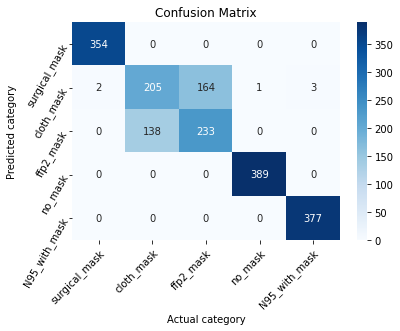

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       0.34      0.41      0.37        37
           2       0.41      0.36      0.38        42
           3       1.00      0.98      0.99        44
           4       1.00      0.97      0.99        38

    accuracy                           0.75       207
   macro avg       0.75      0.74      0.75       207
weighted avg       0.76      0.75      0.76       207

Testing Confusion Matrix: 


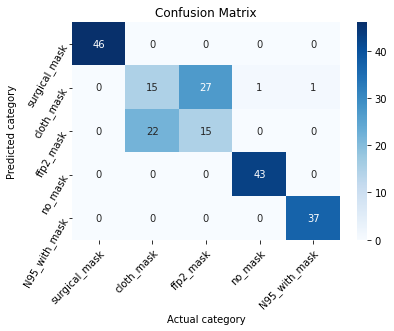

------------Generate Matrix of Male------------
Mask Male Image Classification Report: 
              precision    recall  f1-score   support

           0       0.11      0.20      0.14        15
           1       0.36      0.38      0.37        24
           2       0.00      0.00      0.00         7
           3       0.72      0.62      0.67        29
           4       0.67      0.29      0.41        48

    accuracy                           0.36       123
   macro avg       0.37      0.30      0.32       123
weighted avg       0.51      0.36      0.40       123

Mask Male Image Confusion Matrix: 


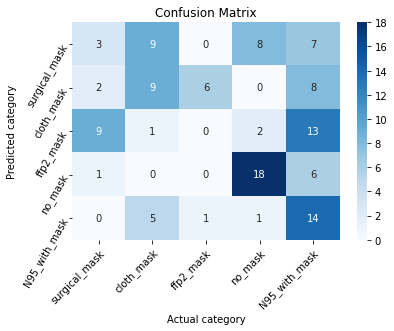

------------Generate Matrix of Female------------
Mask Female Image Classification Report: 
              precision    recall  f1-score   support

           0       0.04      0.06      0.04        18
           1       0.25      0.23      0.24        26
           2       0.00      0.00      0.00         4
           3       0.69      0.58      0.63        31
           4       0.75      0.35      0.48        43

    accuracy                           0.33       122
   macro avg       0.35      0.24      0.28       122
weighted avg       0.50      0.33      0.39       122

Mask Female Image Confusion Matrix: 


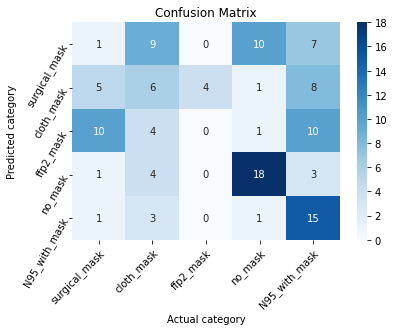

------------Generate Matrix of Children------------
Mask Children Image Classification Report: 
              precision    recall  f1-score   support

           0       0.04      0.10      0.06        10
           1       0.27      0.25      0.26        28
           2       0.08      0.22      0.11         9
           3       0.58      0.75      0.65        20
           4       0.12      0.02      0.04        44

    accuracy                           0.23       111
   macro avg       0.22      0.27      0.22       111
weighted avg       0.23      0.23      0.21       111

Mask Children Image Confusion Matrix: 


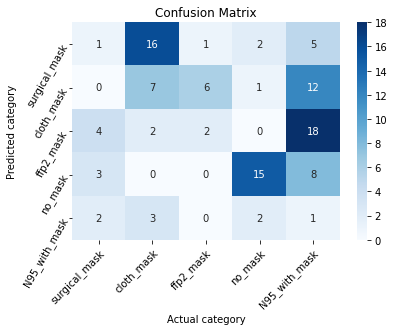

------------Generate Matrix of Young------------
Mask Young Image Classification Report: 
              precision    recall  f1-score   support

           0       0.12      0.12      0.12        25
           1       0.35      0.24      0.29        37
           2       0.08      0.15      0.11        13
           3       0.73      0.79      0.76        24
           4       0.49      0.46      0.48        52

    accuracy                           0.38       151
   macro avg       0.35      0.35      0.35       151
weighted avg       0.40      0.38      0.38       151

Mask Young Image Confusion Matrix: 


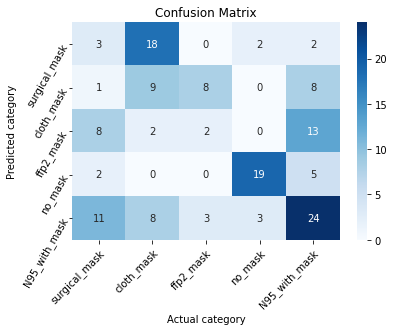

------------Generate Matrix of Old------------
Mask Old Image Classification Report: 
              precision    recall  f1-score   support

           0       0.12      0.16      0.14        19
           1       0.33      0.28      0.31        32
           2       0.00      0.00      0.00        13
           3       0.81      0.64      0.71        33
           4       0.18      0.14      0.15        22

    accuracy                           0.30       119
   macro avg       0.29      0.24      0.26       119
weighted avg       0.37      0.30      0.33       119

Mask Old Image Confusion Matrix: 


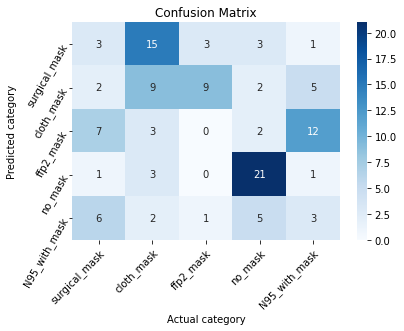

In [ ]:
FaceMaskDetection()